# **Advection Diffusion PDE Solution using DeepXDE**

---




### **Installing the DeepXDE library**

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.4 MB/s eta 0:00:00


###**Importing necessary libraries**

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



###**Defining the Partial Differential Equation**

In [ ]:
# Define the PDE
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # ∂u/∂x
    u_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)  # ∂²u/∂x²
    return u_t + b * u_x - a * u_xx

###**Defining the Initial and Boundary Conditions**

In [ ]:
# Initial condition
def initial_condition(x):
    return 3 * np.sin(4 * np.pi * x[:, 0:1])  # ϕ(x) = 3sin(4πx)

# Boundary condition functions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

### **1. Defining Constants**
### **2. Creating & Training the Model**





In [ ]:
# Define constants
L = 1.0  # Length of the domain in x
T = 1.0  # Time domain
a = 0.1  # Diffusion coefficient
b = 1.0  # Advection coefficient

# Create the geometry and time domain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 0, boundary_left)  # u(0, t) = g0(t) = 0
bc_right = dde.DirichletBC(geomtime, lambda x: 0, boundary_right)  # u(L, t) = g1(t) = 0
ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)  # u(x, 0) = ϕ(x)

# Set up the problem
data = dde.data.TimePDE(geomtime, pde, [bc_left, bc_right, ic], num_domain=5080, num_boundary=160, num_initial=320)

# Define the neural network model
net = dde.maps.FNN([2] + [80] * 5 + [60] * 4 + [40] * 3  + [20] * 2 + [1], "tanh", "Glorot uniform")

# Model and training
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=25000)

Compiling model...
Building feed-forward neural network...
'build' took 0.211718 s

'compile' took 1.643578 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.41e-01, 1.75e-01, 3.12e-01, 4.39e+00]    [6.41e-01, 1.75e-01, 3.12e-01, 4.39e+00]    []  
1000      [2.56e-02, 9.26e-03, 2.80e-02, 2.50e-02]    [2.56e-02, 9.26e-03, 2.80e-02, 2.50e-02]    []  
2000      [2.65e-02, 6.62e-04, 1.38e-02, 5.43e-03]    [2.65e-02, 6.62e-04, 1.38e-02, 5.43e-03]    []  
3000      [3.13e-02, 7.08e-04, 1.20e-02, 8.81e-03]    [3.13e-02, 7.08e-04, 1.20e-02, 8.81e-03]    []  
4000      [4.60e-02, 5.67e-04, 1.51e-02, 7.37e-03]    [4.60e-02, 5.67e-04, 1.51e-02, 7.37e-03]    []  
5000      [2.24e-02, 5.64e-04, 1.21e-02, 3.30e-03]    [2.24e-02, 5.64e-04, 1.21e-02, 3.30e-03]    []  
6000      [2.25e-01, 5.04e-03, 2.70e-02, 3.26e-02]    [2.25e-01, 5.04e-03, 2.70e-02, 3.26e-02]    []  
7000      [2.23e-02, 7.35e-04, 1.11e-02

### **The Analytical Solution**

In [ ]:
def analytical_solution(x, t, n_terms):
    u_xt=np.exp((b/(2*a))*(x-((b*t)/2)))
    sum_term=0
    for n in range(1,n_terms+1):
      Bn=((3*b)/(2*a))*(1+((-1)**(n+1))*(np.exp(-b/(2*a))))
      t1=1/(((b/(2*a))**2)+(((n-4)**2)*((np.pi)**2)))
      t2=1/(((b/(2*a))**2)+(((n+4)**2)*((np.pi)**2)))
      Bn=Bn*(t1-t2)
      Bn=Bn*(np.exp(-a*(n**2)*(np.pi**2)*t)*np.sin(n*np.pi*x))
      sum_term=sum_term+Bn
    return u_xt*sum_term

### **Creating spatial and temporal domain**

In [ ]:
x = np.linspace(0, 1, 500)
t = np.linspace(0, 1, 500)
X, T = np.meshgrid(x, t)
XT = np.vstack([X.flatten(), T.flatten()]).T

### Computing True and Predicted Solution using analytical function and deepXDE model respectively. Then comparing them, calculating the Mean Squared Error.

In [ ]:
# Analytical solution over the grid
U_actual = analytical_solution(X, T, 500).flatten()
# Make predictions using the trained model
U_pred = model.predict(XT).flatten()

In [ ]:
# Calculate Mean Squared Error (MSE) between analytical and predicted solutions
mse = np.mean((U_actual - U_pred) ** 2)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.4499775113659849e-05


### **Plotting the Analytical Solution**

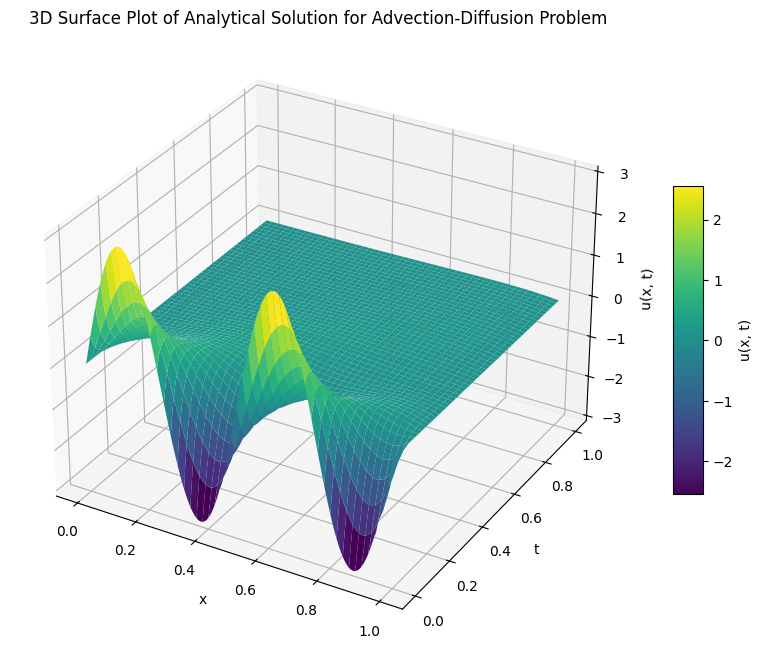

In [ ]:
U = analytical_solution(X, T, 100)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, U, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
ax.set_title("3D Surface Plot of Analytical Solution for Advection-Diffusion Problem")

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="u(x, t)")

plt.show()

### **Plotting the Predicted Solution**

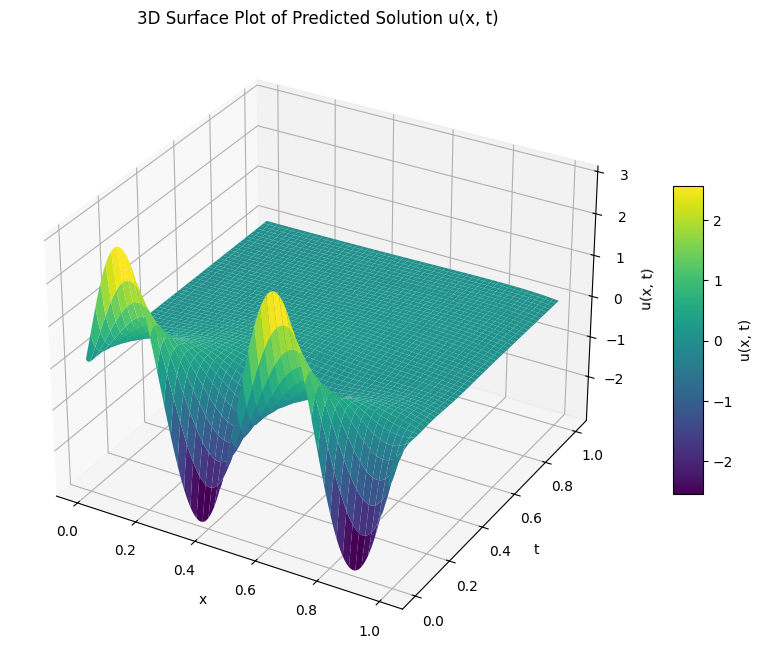

In [ ]:
u_pred = model.predict(XT)
Uu_pred = u_pred.reshape(X.shape)  # Reshape for plotting

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, T, Uu_pred, cmap="viridis", edgecolor="none")

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
ax.set_title("3D Surface Plot of Predicted Solution u(x, t)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="u(x, t)")

plt.show()

### **Plotting the Error between Analytical and Predicted Solutions**

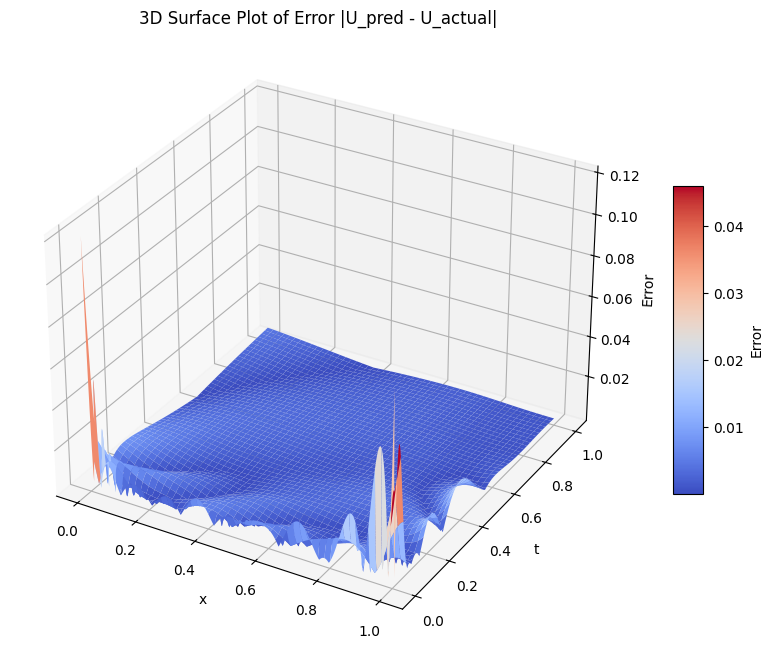

In [ ]:

# Calculate the absolute error between U_pred and U_actual
error = np.abs(U_pred - U_actual).reshape(X.shape)

# Optionally, plot the error as a 3D surface plot for a different perspective
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, T, error, cmap="coolwarm", edgecolor="none")

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Error")
ax.set_title("3D Surface Plot of Error |U_pred - U_actual|")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Error")

plt.show()
